# Multi-Dimensional Degeneracy Detection

Visualize degeneracy detector results on synthetic datasets with **known multi-dimensional relationships**.

**To run experiments**, use the script:
```bash
python /home/x-ctirapongpra/scratch/degen_detector/scripts/run_synthetic_experiments.py --output-dir /home/x-ctirapongpra/scratch/degen_detector/outputs/synthetic
```

This notebook only handles plotting.

In [8]:
try:
    import dill as pickle  # dill can unpickle lambdas
except ImportError:
    import pickle
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams.update({'font.size': 14, 'figure.figsize': (15, 5)})

In [ ]:
# Load results - update this path to your run
import sys

RESULTS_DIR = Path("/home/x-ctirapongpra/scratch/outputs/synthetic")  # Will use latest run

# Find the latest run directory
run_dirs = sorted(RESULTS_DIR.glob("*"), key=lambda p: p.name, reverse=True)
if run_dirs:
    latest_run = run_dirs[0]
    print(f"Loading results from: {latest_run}")
else:
    raise FileNotFoundError(f"No results found in {RESULTS_DIR}. Run the experiments first.")

sys.path.insert(0, '/anvil/scratch/x-ctirapongpra/degen_detector/')
from degen_detector import DegenDetector
from degen_detector.plotting import plot_corner_with_degeneracy, plot_residual_corner

with open(latest_run / "all_results.pkl", "rb") as f:
    all_results = pickle.load(f)

print(f"Loaded {len(all_results)} experiments")

Loading results from: /home/x-ctirapongpra/scratch/outputs/synthetic/20260226_092057
Loaded 3 experiments


In [10]:
def plot_experiment(result, color='steelblue'):
    """Plot MI heatmap, predicted vs actual, and residuals for an experiment."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    samples = result['samples']
    names = result['param_names']
    res = result['result']
    fit = res.best_fit.fit
    
    # MI heatmap
    ax = axes[0]
    mi = res.mi_result.mi_matrix
    im = ax.imshow(mi, cmap='YlOrRd')
    ax.set_xticks(range(len(names)))
    ax.set_yticks(range(len(names)))
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    for i in range(len(names)):
        for j in range(len(names)):
            ax.text(j, i, f'{mi[i,j]:.2f}', ha='center', va='center', fontsize=8,
                    color='white' if mi[i,j] > mi.max()/2 else 'black')
    plt.colorbar(im, ax=ax, shrink=0.8)
    ax.set_title('Mutual Information')
    
    # Predicted vs actual
    ax = axes[1]
    input_idx = [names.index(n) for n in fit.input_names]
    target_idx = names.index(fit.target_name)
    y_actual = samples[:, target_idx]
    y_pred = fit.predict(samples[:, input_idx])
    ax.scatter(y_actual, y_pred, s=2, alpha=0.3, c=color)
    lims = [min(y_actual.min(), y_pred.min()), max(y_actual.max(), y_pred.max())]
    ax.plot(lims, lims, 'k--', lw=1)
    ax.set_xlabel(f'Actual {fit.target_name}')
    ax.set_ylabel(f'Predicted {fit.target_name}')
    ax.set_title(f'R² = {fit.r_squared:.4f}')
    
    # Residuals
    ax = axes[2]
    residuals = y_actual - y_pred
    ax.hist(residuals, bins=50, color=color, edgecolor='white', alpha=0.8)
    ax.axvline(0, color='k', ls='--', lw=1)
    ax.set_xlabel('Residual')
    ax.set_ylabel('Count')
    ax.set_title(f'Residuals (std={np.std(residuals):.4f})')
    
    fig.suptitle(f"{result['ground_truth']}  →  {fit.equation_str}", fontsize=14, y=1.02)
    plt.tight_layout()
    return fig

---
## Experiment 1: Three-Parameter Polynomial

**Ground truth:** z = x² + y + ε

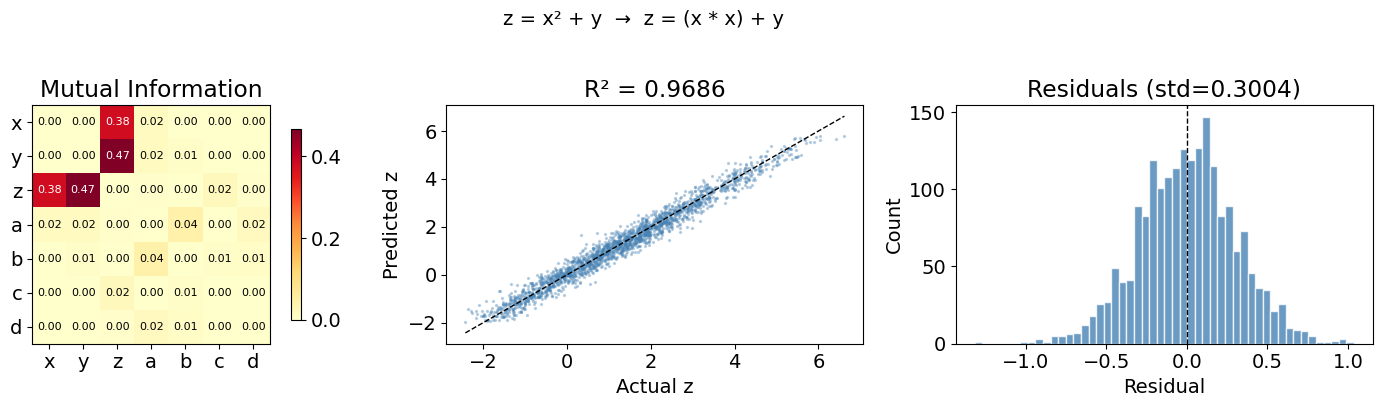

In [11]:
plot_experiment(all_results[0], color='steelblue')
plt.show()

---
## Experiment 2: Three-Parameter Exp/Log

**Ground truth:** z = exp(x) + log(y) + ε

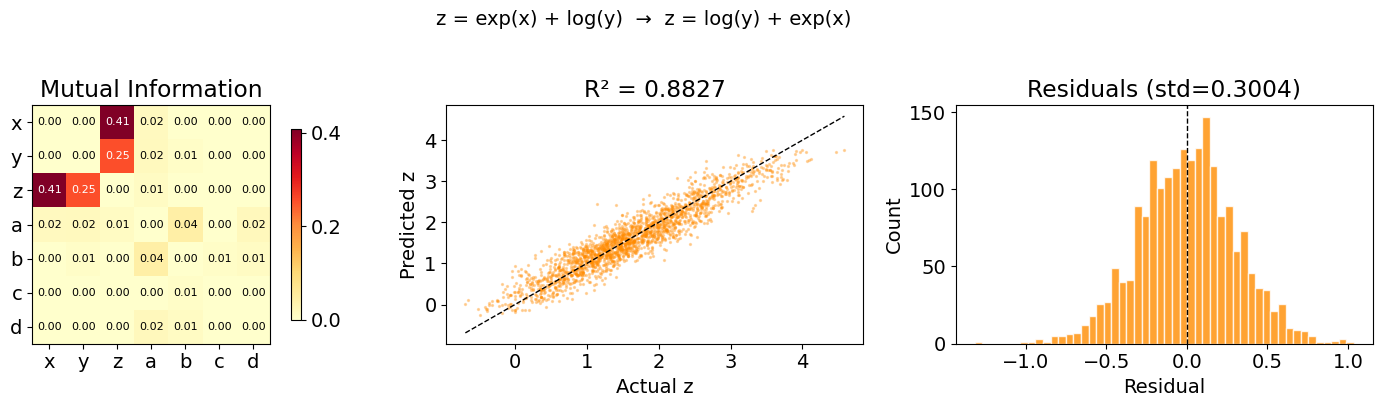

In [12]:
plot_experiment(all_results[1], color='darkorange')
plt.show()

---
## Experiment 3: SBIBM SLCP Benchmark

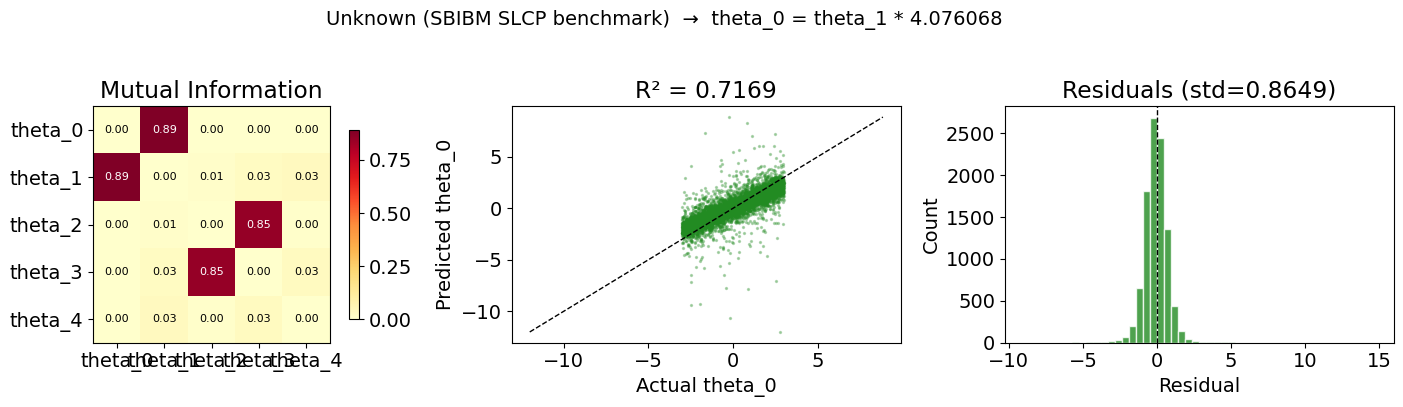

In [13]:
plot_experiment(all_results[2], color='forestgreen')
plt.show()



Verify SBIBM results with corner plots showing all pairwise marginals and highlighting discovered degeneracy equations.

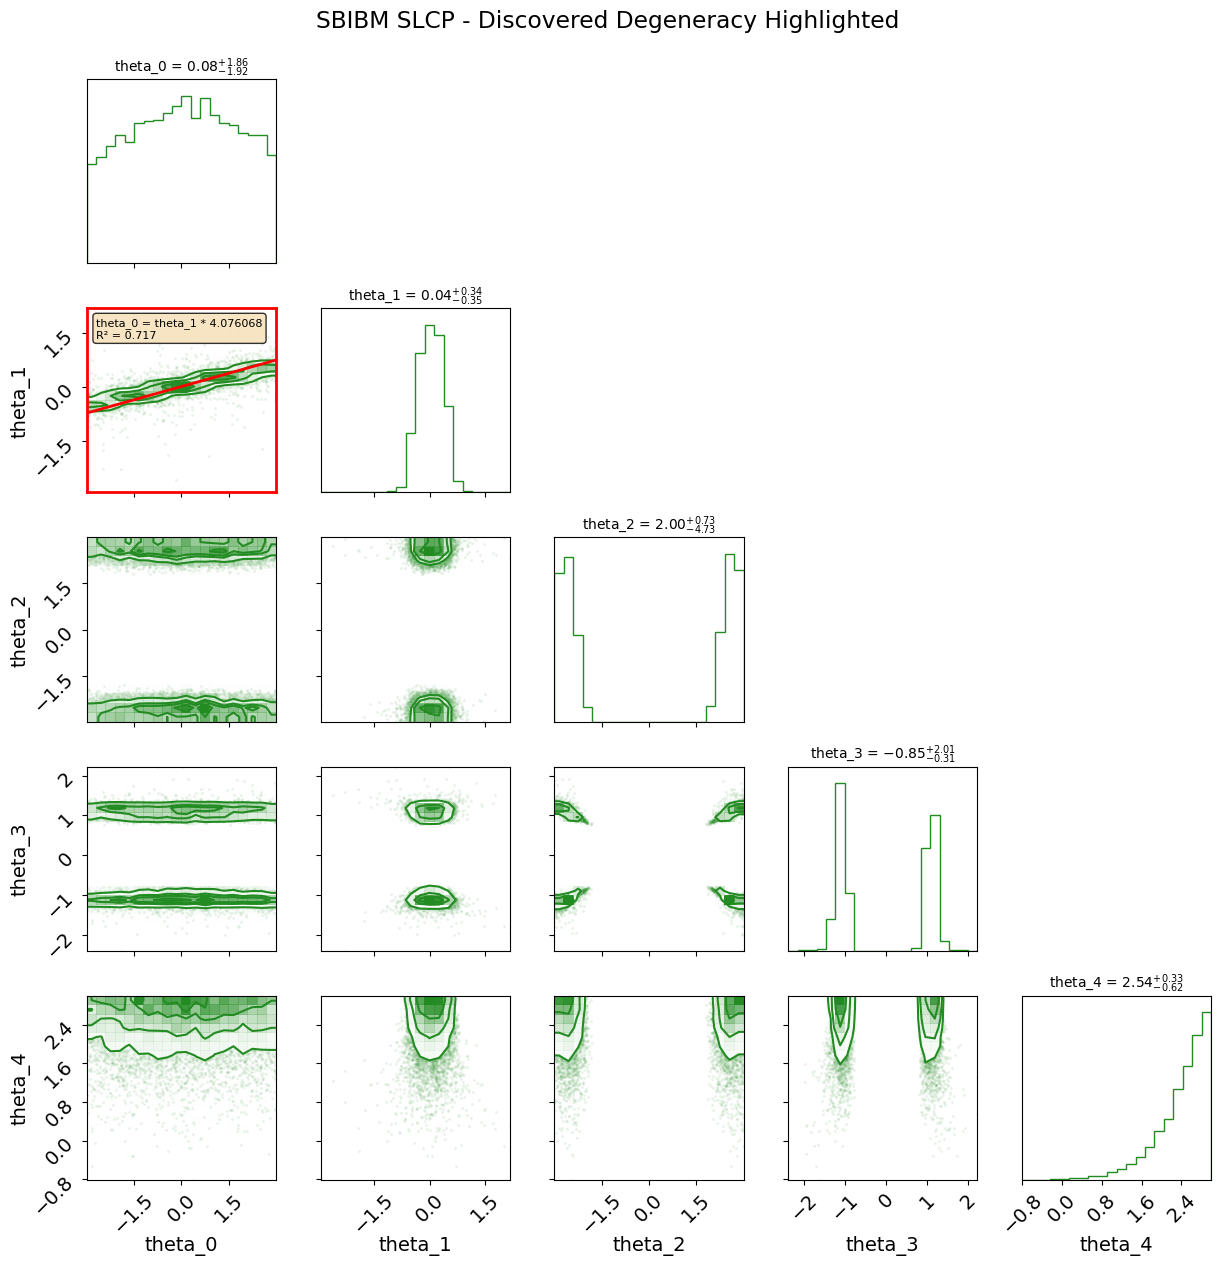

In [ ]:
# SBIBM SLCP corner plot with discovered degeneracy highlighted
sbibm_result = all_results[2]
fig = plot_corner_with_degeneracy(
    sbibm_result['samples'],
    sbibm_result['param_names'],
    sbibm_result['result'],
    color='forestgreen'
)
fig.suptitle('SBIBM SLCP', y=1.02)
plt.show()

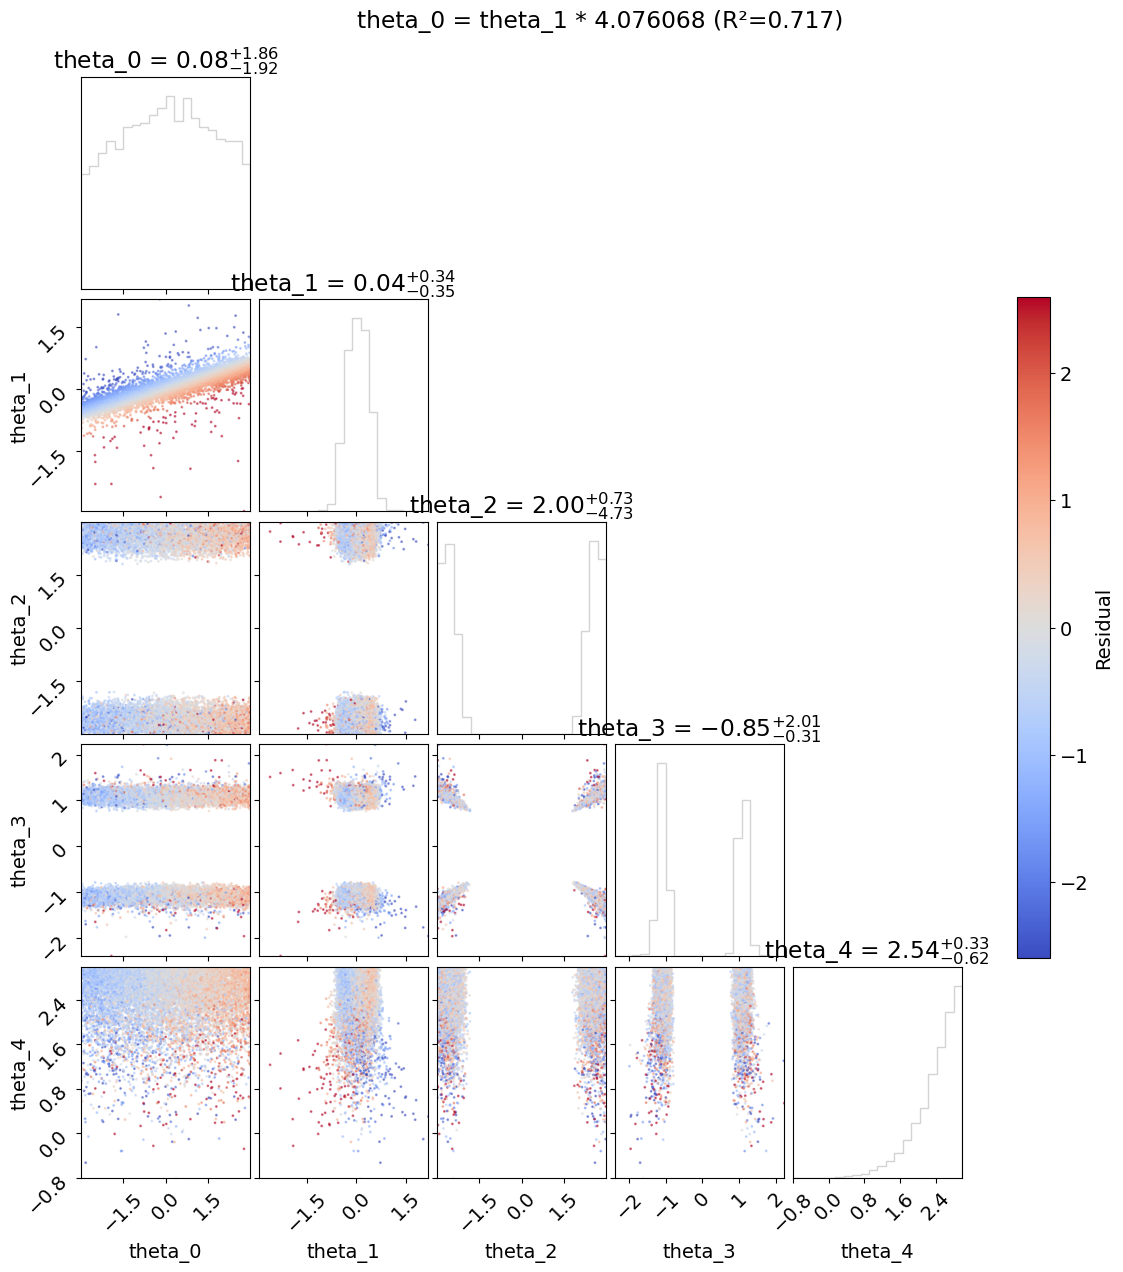

In [16]:
# Residual-colored corner plot - shows where the equation fits well vs poorly
fig = plot_residual_corner(
    sbibm_result['samples'],
    sbibm_result['param_names'],
    sbibm_result['result'].best_fit.fit
)
plt.show()